In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons
import random
import numpy as np
from torch_geometric.data import Data
import torch
import os.path as osp
from torch_geometric.data import Dataset, download_url

In [2]:
def draw_blobs(G, pos, y):
    plt.figure(figsize=(20, 6))
    
    colors=['yellow','red']
    color_map=[colors[y[node]] for node in G]
    
    if nx.is_weighted(G):
        edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])
    else:
        edge_labels = dict([((u,v,), f"{1}") for u,v in G.edges()])
    
    nx.draw(G, pos, node_color=color_map, with_labels=True,alpha=0.5, node_size=500,font_size=16)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_color='red')
    
    plt.show()

In [3]:
def draw_blobs_data(G, data, edge_attr='edge_attr'):
    plt.figure(figsize=(30, 20))    
    
    X = data.x.numpy()
    y = data.y.numpy()
    
    pos={i:X[i] for i in range(X.shape[0])}
    
    colors=['black','blue']
    train_colors=['red', 'yellow']
    
    color_map=[]
    
    for node in G:
        if data.train_mask[node]==True:
            color_map.append(train_colors[y[node]])
        else:
            color_map.append(colors[y[node]])
            
    
#     edge_labels = nx.get_edge_attributes(G, edge_attr)    
#     print(edge_labels)
    
    #if len(edge_labels)==0:
    
    if nx.is_weighted(G):
        print("weighted graph")
        edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])
    else:
        edge_labels = dict([((u,v,), f"{1}") for u,v in G.edges()])

#     else:
#         edge_labels = {key:f"{value:0.2f}" for key,value in edge_labels.items()}
        
#     print(edge_labels)
    
    nx.draw(G, pos, node_color=color_map, with_labels=True,alpha=0.5, node_size=500,font_size=16)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_color='red', label_pos=0.80)
    
    plt.show()

In [4]:
def draw_blobs_data_few(G, data, edge_attr='edge_attr'):
    plt.figure(figsize=(10, 10))    
    
    X = data.x.numpy()
    y = data.y.numpy()
    
    pos={i:X[i] for i in range(X.shape[0])}
    
    colors=['black','blue']
    train_colors=['red', 'yellow']
    
    color_map=[]
    
    for node in G:
        if data.train_mask[node]==True:
            color_map.append(train_colors[y[node]])
        else:
            color_map.append(colors[y[node]])
            
    
#     edge_labels = nx.get_edge_attributes(G, edge_attr)    
#     print(edge_labels)
    
    #if len(edge_labels)==0:
    
    if nx.is_weighted(G):
        print("weighted graph")
        edge_labels = dict([((u,v,), f"{d['weight']:.2f}") for u,v,d in G.edges(data=True)])
    else:
        edge_labels = dict([((u,v,), f"{1}") for u,v in G.edges()])

#     else:
#         edge_labels = {key:f"{value:0.2f}" for key,value in edge_labels.items()}
        
#     print(edge_labels)
    
    #nx.draw(G, pos, node_color=color_map, with_labels=True,alpha=0.5, node_size=1000,font_size=32)
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_color='red', connectionstyle='arc3, rad = 0.1')
    
    labels = {i:i for i in G.nodes()}
    
    nx.draw_networkx_nodes(G, pos, node_color=color_map,alpha=0.5, node_size=750)
    #nx.draw_networkx_edges(G, pos, connectionstyle='arc3, rad = 0.1')
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos, labels=labels,alpha=0.5,font_size=32)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,font_color='red', label_pos=0.80)
    
    plt.show()

In [5]:
def generate_moon(n_samples=100, degree=10, random_state=0):
    b_samples=200

#     centers = [(10, 10), (25, 25)]
#     X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)
#     X, y = make_circles(n_samples=n_samples, factor=0.3, noise=0.05, random_state=0)
    
    X, y = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state, shuffle=False)
    
    minx=np.min(X,0)
    X=X-minx
    minx=np.min(X,0)
        
    N=X.shape[0]
    nodes=list(range(N))

    G = nx.DiGraph()
    G.add_nodes_from(nodes)

    for u in nodes:
        
        Vs = np.random.choice(N, degree, replace=False)
        
        for v in Vs:
            if G.has_edge(u, v) or G.has_edge(v, u):
                None            
            elif u==v:
                None
            else:
                G.add_edge(u,v,weight=1)          
        
    return G, X, y


def getMoonDataset(n_samples=100, degree=5, random_state=0, train=0.1):    
    G, X, y = generate_moon(n_samples,degree, random_state)
    
    #train=0.1;
    val=0.3;test=max(0,1-train-val)

    l=len(y)
    indexs=list(range(l))
    random.shuffle(indexs)

    train_index=indexs[:int(train*l)]
    val_index=indexs[int(train*l):int(train*l)+int(val*l)]
    test_index=indexs[int(train*l)+int(val*l):]

    train_mask=torch.zeros(l, dtype=torch.bool)
    train_mask[train_index]=True
    val_mask=torch.zeros(l, dtype=torch.bool)
    val_mask[val_index]=True
    test_mask=torch.zeros(l, dtype=torch.bool)
    test_mask[test_index]=True

    
    edges=np.array(list(G.edges))
    ledge_index=[list(edges[:,0]),list(edges[:,1])]
    ledge_index[0].extend(list(edges[:,1]))
    ledge_index[1].extend(list(edges[:,0]))
    
    
    edge_index=torch.tensor(ledge_index, dtype=torch.long)
    edge_weight=torch.ones((len(ledge_index[0]),1),dtype=torch.float)    
    X = torch.tensor(X, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)
    
    data=Data(train_mask=train_mask, 
              val_mask=val_mask, 
              test_mask=test_mask, 
              y=y, x=X,
              edge_index=edge_index, edge_weight=edge_weight)
            
    return G, data
    

def drawMoon(G, data):   
    X = data.x.numpy()
    y = data.y.numpy()
    
    X_pos={i:X[i] for i in range(X.shape[0])}
    draw_blobs(G, X_pos, y)


In [6]:
class MoonDataset(Dataset):
    def __init__(self, n_samples=100, degree=10, train=0.1,
                 transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.n_samples=n_samples
        self.degree=degree
        self.train=train
        

    @property
    def processed_file_names(self):
        return 'moon'
    
    @property
    def processed_dir(self):
        return ''

    
    @property
    def num_node_features(self):
        return 2
    
    @property
    def num_classes(self):
        return 2

    def len(self):
        return 10

    def get(self, idx):
        
        G, data = getMoonDataset(self.n_samples,self.degree, random_state=idx, train=self.train)
        
        return G, data


In [10]:
# dataset = MoonDataset(n_samples=5, degree=2, train=0.5)    
# G, data =dataset[0]    
# print(data.edge_index)

weighted graph


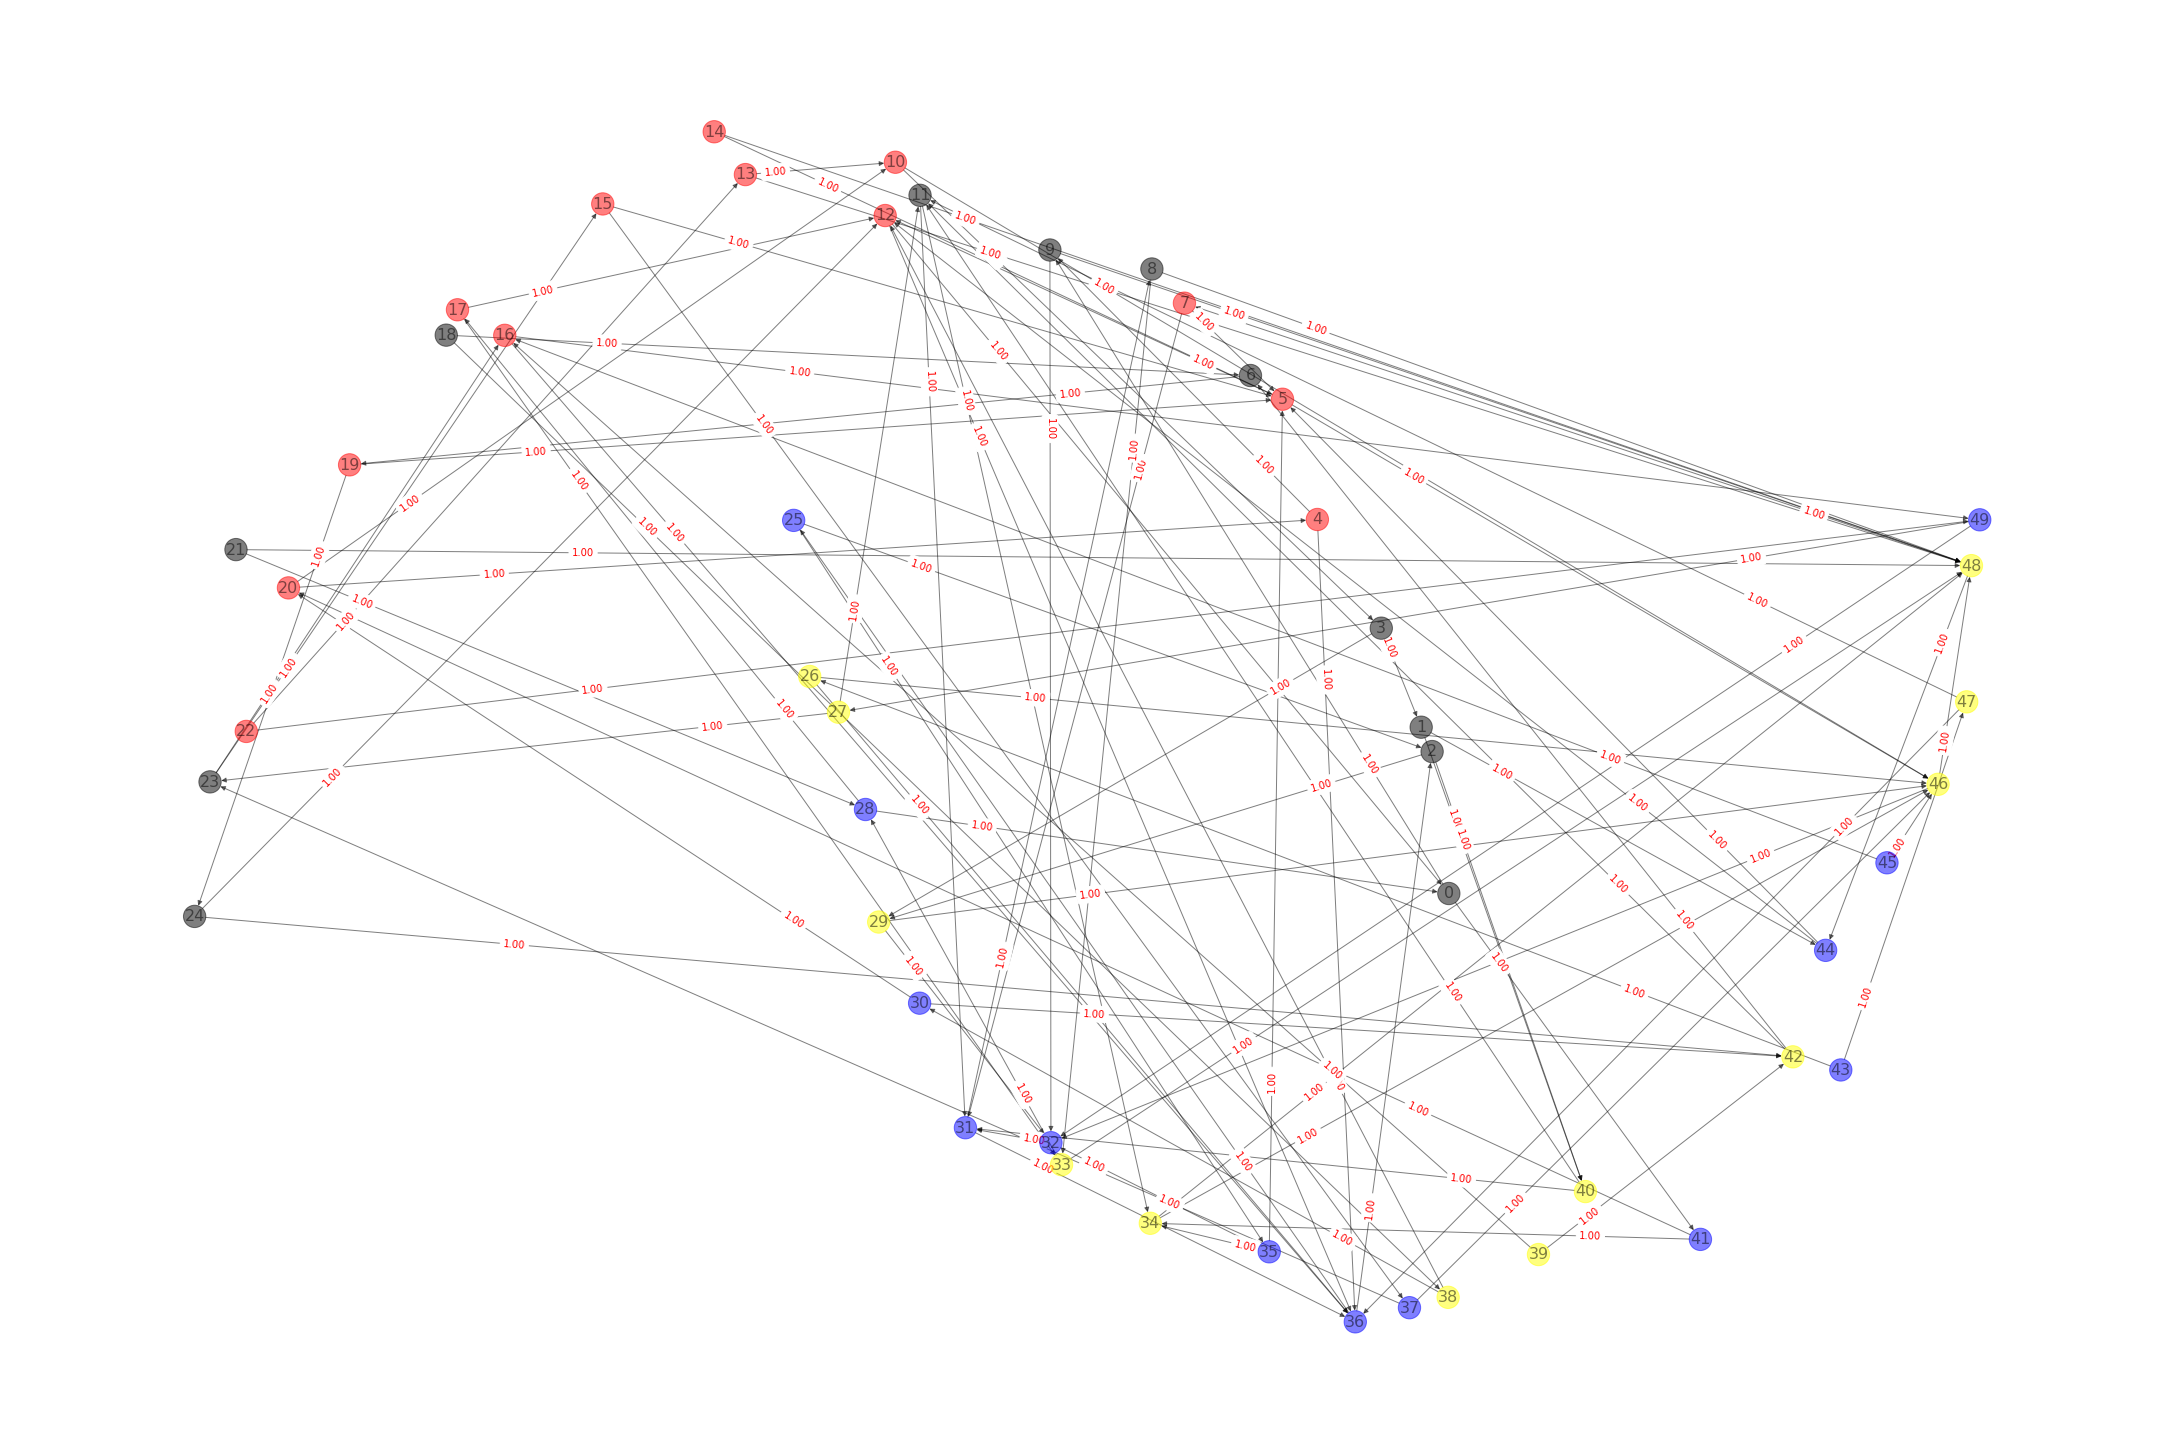


Dataset: MoonDataset(10):
Number of graphs: 10
Number of features: 2
Number of classes: 2

Data(x=[50, 2], edge_index=[2, 198], y=[50], train_mask=[50], val_mask=[50], test_mask=[50], edge_weight=[198, 1])
Number of nodes: 50
Number of edges: 198
Average node degree: 3.96
Number of training nodes: 25
Training node label rate: 0.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [11]:
if __name__ == "__main__":
    
    dataset = MoonDataset(n_samples=50, degree=2, train=0.5)    
    G, data =dataset[0]    
    #G, data = getMoonDataset(100,5)
    #drawMoon(G,data)    
    draw_blobs_data(G, data)
    
    print()
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

    #data = dataset[0]  # Get the first graph object.

    print()
    print(data)
    print('===========================================================================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

   
    None